# Th analysis

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   mpl_toolkits.mplot3d                    import Axes3D

In [2]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

## Read the corrections table
Reads the corrections table from the specified file and creates a function that returns the correction factor for a given (x,y) location.

In [3]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/run4628_corrections_5.3mm.h5"
fcorr     = dstf.load_xy_corrections(corr_file)

## Read in the output of Penthesilea
Reads in Penthesilea output from the runs listed

In [4]:
def merge_NN_hits(hits_all,hits_nonNN):

    # Iterate through the nonNN dictionary and update the energies including the NN hits from the "all" dictionary.
    for (evt,hc) in hits_nonNN.items():

        # Get the corresponding collection of all hits.
        hc_all = hits_all[evt]
            
        # Add energy from all NN hits to hits in closest slice.
        for h1 in hc_all.hits:

            if(h1.Q == NN):

                # Find the hits to which the energy will be added.
                zdist_min = -1
                h_add = []
                for h2 in hc.hits:
                    zdist = np.abs(h1.Z - h2.Z)
                    if(zdist_min < 0 or zdist < zdist_min):
                        zdist_min = zdist
                        h_add = []
                        h_add.append(h2)
                    elif(zdist == zdist_min):
                        h_add.append(h2)

                # Add the energy.
                hadd_etot = sum([ha.E for ha in h_add])
                for ha in h_add:
                    ha.energy += h1.E*(ha.E/hadd_etot)
                    
        # Check the sum of the energy.
        #e1 = sum([hh.E for hh in hc_all.hits])
        #e2 = sum([hh.E for hh in hc.hits])
        #if(abs(e1 - e2) > 0.001):
        #    print("ERROR")


In [5]:
tlife  = 1544


In [6]:
fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4623/tracks/tracks_4623.h5"
hits_all = load_hits(fname)
hits = load_hits_skipping_NN(fname)

In [7]:
# Create the corrected hit collections (summed over all runs) for 
#  fully corrected (c), geometry-only corrected (g), tau-only corrected (t), and uncorrected (u) events.
hitc_uevt = []; hitc_cevt = []; hitc_gevt = []; hitc_tevt = []

for ee,hc in hits.items():
    hc_ucorr = []; hc_corr = []; hc_gcorr = []; hc_tcorr = []
    for hh in hc.hits:

        hecorr = hh.E*fcorr(hh.X,hh.Y).value/np.exp(-hh.Z/1200.)
        hegcorr = hh.E*fcorr(hh.X,hh.Y).value
        hetcorr = hh.E/np.exp(-hh.Z/tlife)

        hucorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hh.E)
        hcorr  = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
        hgcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hegcorr)
        htcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hetcorr)

        hc_ucorr.append(hucorr); hc_corr.append(hcorr); hc_gcorr.append(hgcorr); hc_tcorr.append(htcorr)

    # Only save events with >= 2 hits.
    if(len(hc_corr) >= 1):
        hitc_uevt.append(hc_ucorr)
        hitc_cevt.append(hc_corr)
        hitc_gevt.append(hc_gcorr)
        hitc_tevt.append(hc_tcorr)

In [8]:
# Calculation of key quantities
evt_x = []; evt_y = []; evt_z = []; evt_R = []; evt_E = []; evt_Eavg = []; evt_Eratio = []
hit_E = []; hit_x = []; hit_y = []; hit_z = []
evt_Emin = []; evt_Emax = []
evt_deltaX = []; evt_deltaY = []; evt_deltaZ = []

for ee in range(len(hitc_cevt)):

    for hit in hitc_cevt[ee]:
        hit_E.append(hit.E[0])
        hit_x.append(hit.XY[0])
        hit_y.append(hit.XY[1])
        hit_z.append(hit.Z)
        
    Esum = sum([hh.E for hh in hitc_cevt[ee]])[0]
    Eavg = Esum / len(hitc_cevt[ee])
    Emin = min([hh.E for hh in hitc_cevt[ee]])[0]
    Emax = max([hh.E for hh in hitc_cevt[ee]])[0]
    xavg = sum([hh.X*hh.E for hh in hitc_cevt[ee]])[0]/Esum
    yavg = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])[0]/Esum
    zavg = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])[0]/Esum
    
    xmin = min([hh.X for hh in hitc_cevt[ee]])
    xmax = max([hh.X for hh in hitc_cevt[ee]])
    ymin = min([hh.Y for hh in hitc_cevt[ee]])
    ymax = max([hh.Y for hh in hitc_cevt[ee]])
    zmin = min([hh.Z for hh in hitc_cevt[ee]])
    zmax = max([hh.Z for hh in hitc_cevt[ee]])
    
    evt_E.append(Esum)
    evt_Eavg.append(Eavg)
    evt_Eratio.append(Eavg/Emax)
    evt_x.append(xavg)
    evt_y.append(yavg)
    evt_z.append(zavg)
    evt_R.append(np.sqrt(xavg**2 + yavg**2))
    evt_Emin.append(Emin)
    evt_Emax.append(Emax)
    evt_deltaX.append(abs(xmax - xmin))
    evt_deltaY.append(abs(ymax - ymin))
    evt_deltaZ.append(abs(zmax - zmin))

## Control Plots

### # of hits per event

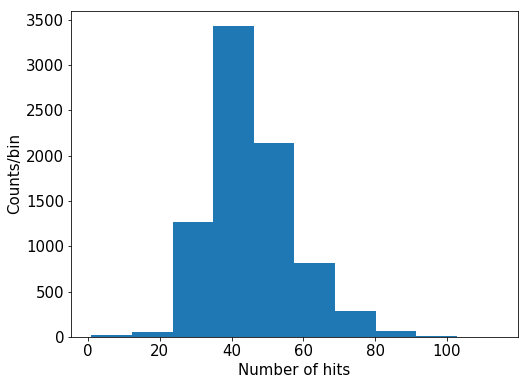

In [9]:
plt.hist(list([len(evt) for evt in hitc_cevt]))
plt.xlabel('Number of hits')
plt.ylabel('Counts/bin')

### Hit energy

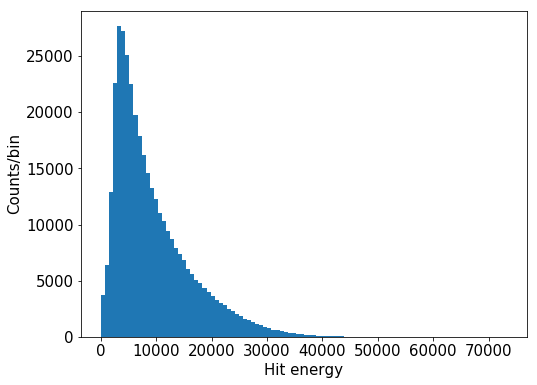

In [10]:
plt.hist(hit_E, 100);
plt.xlabel('Hit energy')
plt.ylabel('Counts/bin')

### Event Energy

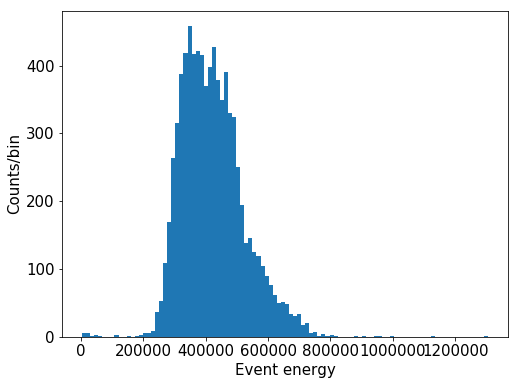

In [11]:
plt.hist(evt_E, 100)
plt.xlabel('Event energy')
plt.ylabel('Counts/bin')

### XYZ Hit position 

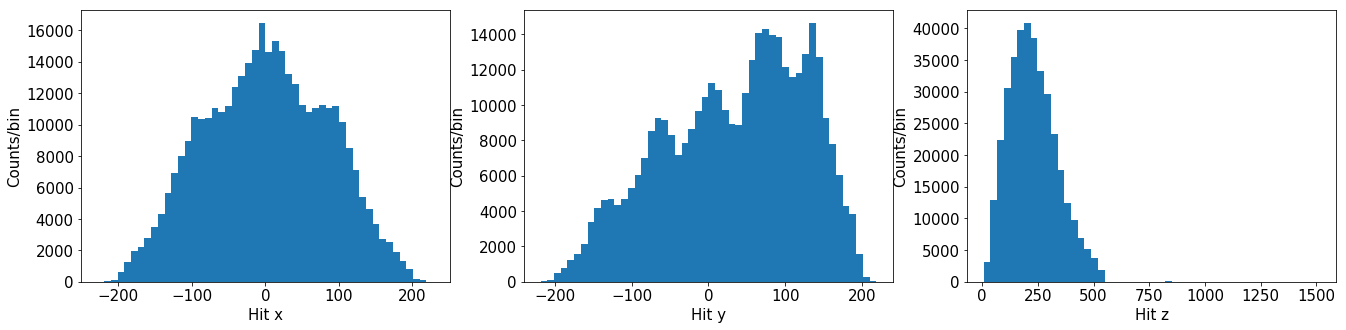

In [12]:
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(22.5)

ax1 = fig.add_subplot(131)
plt.hist(hit_x,bins=50)
plt.xlabel('Hit x')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(132)
plt.hist(hit_y,bins=50)
plt.xlabel('Hit y')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(133)
plt.hist(hit_z,bins=50)
plt.xlabel('Hit z')
plt.ylabel('Counts/bin')

## Average XYZ

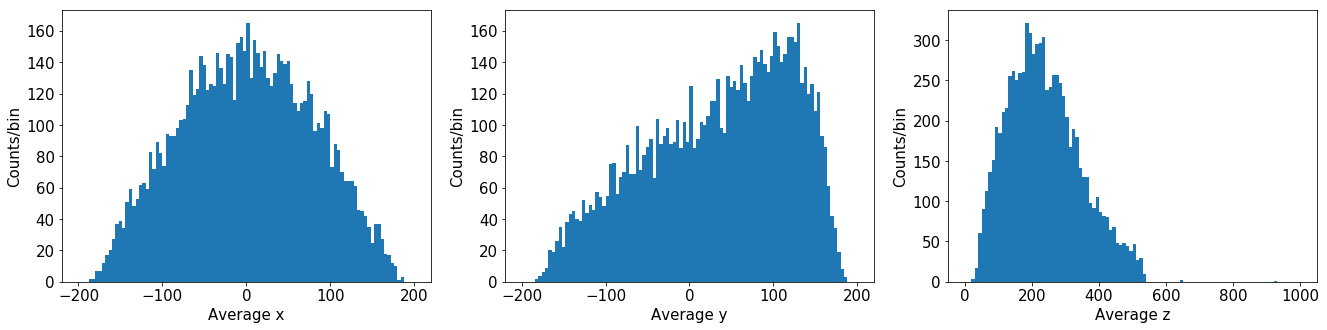

In [13]:
nbins_xyz = 100
xr_min = -200; xr_max = 200
yr_min = -200; yr_max = 200
zr_min = 0; zr_max = 1000
    
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(22.5)

ax1 = fig.add_subplot(131)
plt.hist(evt_x, nbins_xyz, [xr_min,xr_max])
plt.xlabel('Average x')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(132)
plt.hist(evt_y, nbins_xyz, [yr_min,yr_max])
plt.xlabel('Average y')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(133)
plt.hist(evt_z, nbins_xyz, [zr_min,zr_max])
plt.xlabel('Average z')
plt.ylabel('Counts/bin')

## Hit energies

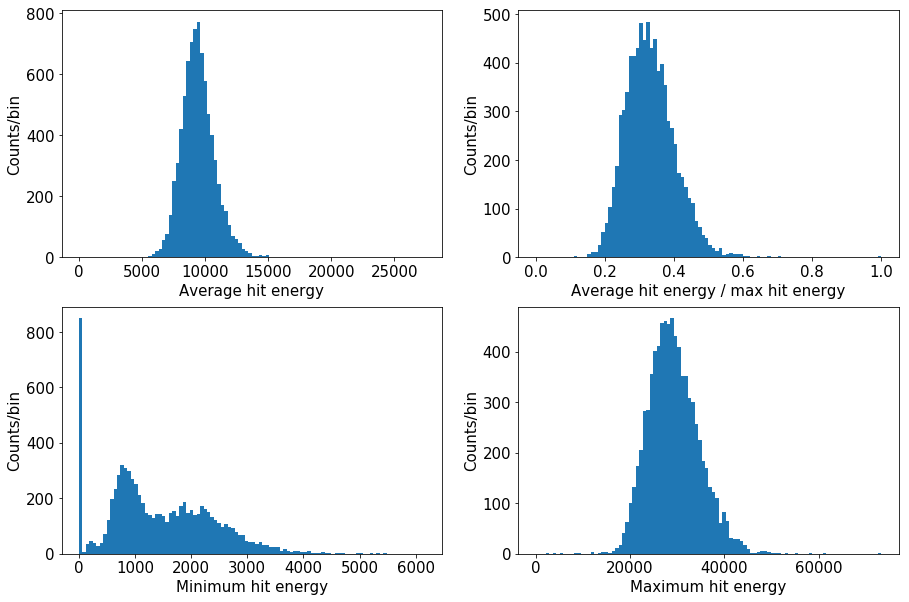

In [14]:
nbins_E = 100; nbins_Eratio = 100; nbins_Emin = 100; nbins_Emax = 100

fig = plt.figure()
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221)
plt.hist(evt_Eavg, nbins_E, [0,max(evt_Eavg)])
plt.xlabel('Average hit energy')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(evt_Eratio, nbins_Eratio, [0,max(evt_Eratio)])
plt.xlabel('Average hit energy / max hit energy')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(evt_Emin, nbins_Emin, [0,max(evt_Emin)])
plt.xlabel('Minimum hit energy')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(evt_Emax, nbins_Emax, [0,max(evt_Emax)])
plt.xlabel('Maximum hit energy')
plt.ylabel('Counts/bin')

## Projections x-y, x-z, y-z

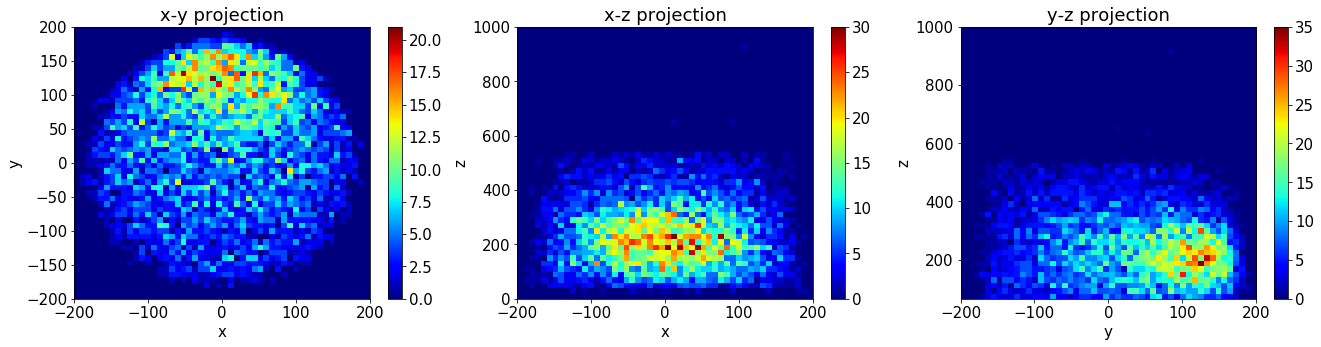

In [15]:
nbins_xyz = 50
xr_min = -200; xr_max = 200
yr_min = -200; yr_max = 200
zr_min = 0; zr_max = 1000

fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(22.5)

# x-y projection
ax1 = fig.add_subplot(131)
#ax1.set_aspect('equal')
plt.hist2d(evt_x, evt_y, (nbins_xyz, nbins_xyz), ((xr_min, xr_max), (yr_min, yr_max)), cmap='jet')
plt.colorbar()
ax1.set_title("x-y projection")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# correction factor error
ax2 = fig.add_subplot(132)
#ax2.set_aspect('equal')
plt.hist2d(evt_x, evt_z, (nbins_xyz, nbins_xyz), ((xr_min, xr_max), (zr_min, zr_max)), cmap='jet')
plt.colorbar()
ax2.set_title("x-z projection")
ax2.set_xlabel("x")
ax2.set_ylabel("z")

# correction factor statistics
ax3 = fig.add_subplot(133)
#ax3.set_aspect('equal')
plt.hist2d(evt_y, evt_z, (nbins_xyz, nbins_xyz), ((yr_min, yr_max), (zmin, zr_max)), cmap='jet')
plt.colorbar()
ax3.set_title("y-z projection")
ax3.set_xlabel("y")
ax3.set_ylabel("z")

## Energy vs. average z and R

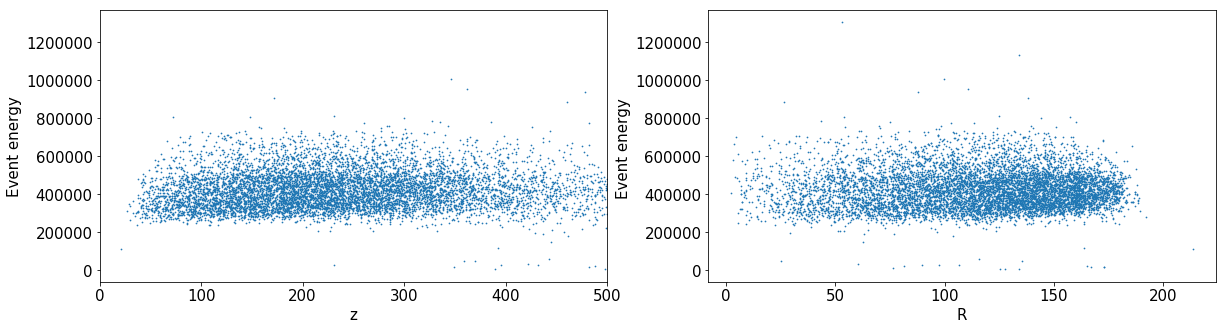

In [16]:
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(121)
ax1.scatter(evt_z,evt_E,s=0.5)
plt.xlabel('z')
plt.ylabel('Event energy')
plt.xlim([0,500])

ax2 = fig.add_subplot(122);
ax2.scatter(evt_R,evt_E,s=0.5)
plt.xlabel('R')
plt.ylabel('Event energy ')

## Energy vs. time

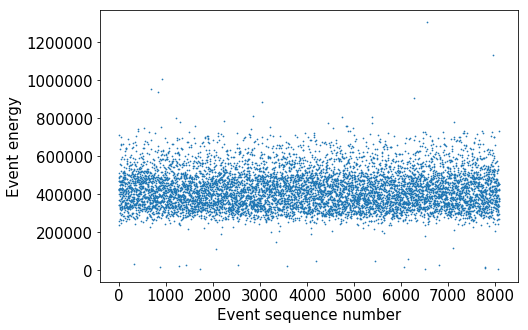

In [19]:
# Energy vs. event (effectively "time")
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111)
ax1.scatter(range(len(evt_E)),evt_E,s=0.5)
plt.xlabel('Event sequence number')
plt.ylabel('Event energy')

## x, y, z ranges (deltaX, deltaY, deltaZ)

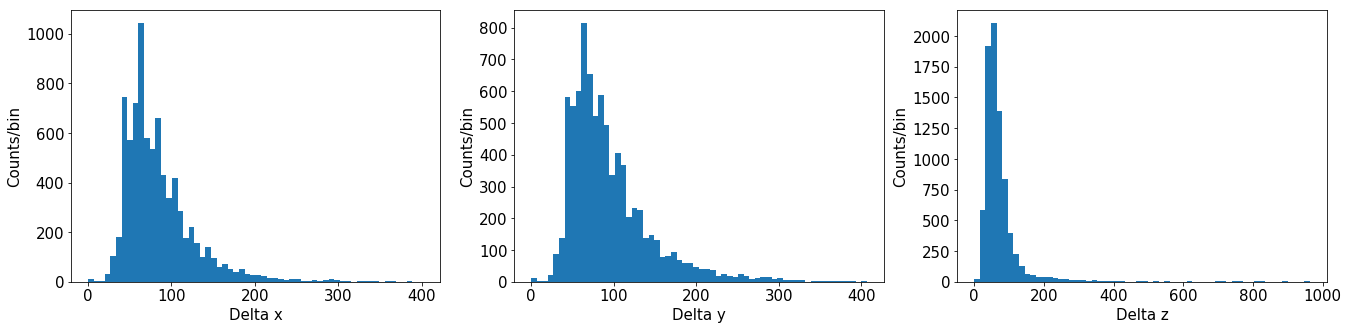

In [18]:
nbins_dxyz = 60
    
fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(22.5)

ax1 = fig.add_subplot(131)
plt.hist(evt_deltaX, nbins_dxyz)
plt.xlabel('Delta x')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(132)
plt.hist(evt_deltaY, nbins_dxyz)
plt.xlabel('Delta y')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(133)
plt.hist(evt_deltaZ, nbins_dxyz)
plt.xlabel('Delta z')
plt.ylabel('Counts/bin')